# Evaluating Causal Models

In the previous chapter, we saw how to build a model that can segment our entities into how responsive they are to a treatment. In techincal terms, we've build a model such that it partitons the entities not on \\(Y\\), like a prediction model would do, but in the treatment elasticity \\(\frac{\delta y}{ \delta t}\\).

The problem that arises next is how can we evaluate this model? In other words, how can we check if this model is any good? Unlike with a predictive model, where we can observe the true value of \\(y\\), elasticity is not something we can see on an idividual level. It is as if every entity had an underlying responsiveness, denoted by the slope of the line from treatment to outcome, but that we can't measure.

![img](./data/img/causal-model/elasticity.png)

This is a very very very hard thing to wrap our heads around and it took me about 2 years to get into something that is not a defenitive answer, but it works. The trick is to use aggregate measurements of elasticity. Even if you can't estimate elasticity individually, you can do it for a group and that is what we will explore.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

Consider again our data from icecream sales. Now, we have two sources. The first consists of non random data. In this source, price has been set naturaly, perhaps by the intuition of the icecream seller. On the second source, `prices_rnd`, prices where randomly set, perhaps in some sort of experiment to understand how price afects sales.

We will use the non random data to estimate our causal models and the random data to validate it. As we will, see, random data is very valuable for this purpose, however, in real life, it is often expensive to collect random data (why would you set prices at random if you know some of them are not very good ones and will only make you loose money???). So, what tends to happen is that we often have an abundance of data where the treatment is **NOT** random and very few, if any, random data.

And just in case you forgot, here is what the data looks like.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv")
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv")
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


Now, lets train two models. The first one will be a linear regression with interactions terms so that elasticity is allowed to vary between units. 

$$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + e_i
$$


In [3]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

The second model will be fully non parametric ML predictive model

$$
sales_i = G(X)_i + e_i
$$


In [4]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y]);

And just to make sure the model is not heavly overfitted, we can show the \\(R^2\\) the data we've used to train it and on new, unseen data.(For those more versed in Machine Learning, notice that some drop in performance is expected, because there is a concept drift. The model was trained in data where price is not random, but the test set has only randomized prices). 

In [5]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


After training our models, we will get the elasticity from the regression model. Again, we will resort to a numerical aproximation

$$
\frac{\delta y(t)}{\delta t} \approx  \frac{y(t+h) - y(t)}{h}
$$

To summarize, we will have our elasticity model, given by the linear regression where we apply the above aproximation to gen an elasticity prediction. We will also have a predictive ML model. Besides those, let's also include a random model. The idea is that this model just outputs random numbers as predictions. It is obviously not very usefull, but it shall serve well as a benchmark.

In [6]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "m0_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
    "m1_pred": predict_elast(m1, prices_rnd), ## elasticity model
    "m2_pred": m2.predict(prices_rnd[X]), ## predictive model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,m0_pred,m1_pred,m2_pred
0,25.8,1,0.3,7,230,0.696469,-13.096964,224.067406
1,22.7,3,0.5,4,190,0.286139,1.054695,189.889147
2,33.7,7,1.0,5,237,0.226851,-17.362642,237.255157
3,23.0,4,0.5,5,193,0.551315,0.564985,186.688619
4,24.4,1,1.0,3,252,0.719469,-13.717946,250.342203


## Elasticity by Model Band

Now that we have our predictions for treatment elasticity, we need to evaluate how good they are. And remember, we can't observe elasticity, so there isn't a groud simple truth we can use. Instead, let's think back to what we want from our elasticity models. Pehaps that will give us some insights into how we should evaluate them. 

The idea of making treatment elasticity models came from the necessity of finding which units are more sensitive to the treatment and which are less. It came from a desire for personalization. Maybe a marketing campaing is very effective in only one segment of the population. Maybe discounts only work for some type of customers. Causal models should help us find which customers will respond better and worse to a proposed treatment. They should be able to separate entities into how elastic or sensitive they are to the treatment - price, in our case.

If we partition ou dataset into equal sized bands defined by our model, we want the first partition to be more sentitive to the treatment that the latter. There is a very simple visual way to check this. It is not the ultimate evaluation method, but something I always do as a vizual check. The idea boild down to ploting the elasticity on each band and seeing if they are ordered as we want them to be. 

Of course, we can't neven know the true elasticity, but we can estimate it prety easely **if we have random data**. Given any set of data where the treatment was randomly assigned, we have that the elasticity is the slope of the line maping from the treatment to the outcome. In other words, elasticity is the \\(\hat{\beta_1}\\) we get from estimating the following model.

$$
y_i = \beta_0 + \beta_1t_i + e_i
$$

From the theory on simple linear regression, we know that

$$
\hat{\beta_1}=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

where \\(\bar{t}\\) is the sample average for the treatment and \\(\bar{y}\\) is the sample average for the outcome. Here is what that looks like in code

In [7]:
@curry
def elast(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

With that out of the way, we can procede with our visual check. First, we will partition our dataset into quantiles of a model predictions. This will create ordered partitions of equal size. If a model is any good, the first partition should have the lowest elasticity, the second partition, the second lowest and so on. The final partition should have only the most elastic units. Here is the function that define the bands or partitions and then estimates the elasticity for each of them

In [8]:
def elast_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)})
            .groupby(f"{pred}_band")
            .apply(elast(y=y, t=t)))

What we can do now is plot the elasticity by band, with the bands defines by each model. To better understand this, consider, M0, the random model. On the image below, we can see that it's elasticity is not well ordered at all. The first band has an elasticity of -2, the sixth band has an elasticity of about -3 and the last band, of -2 again. Rougthly speaking, all the elasticities are clore to the average. This is expected, for a random model. Since its random, each partitions defined by the random model is a random piece of the entire sample, so its not crazy to think each one will have an elasticity wich is close to the elasticity on the entire sample. This is not a very good propriety if we want to order by how sensitive the units are to the treatment, though. Now, the other models are more interetings.

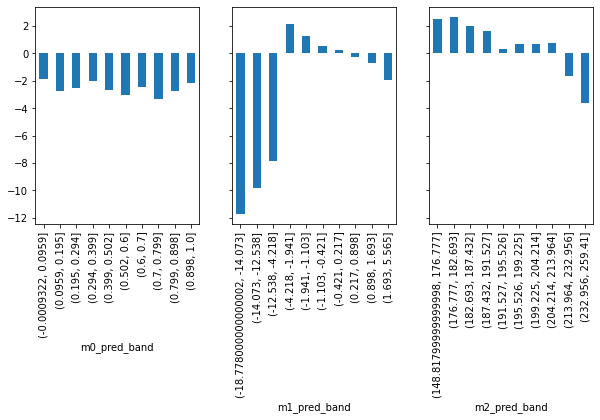

In [9]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in enumerate(axs):
    elast_by_band(prices_rnd_pred, f"m{m}_pred", "sales", "price").plot.bar(ax=ax)

The elasticity model have relly low elasticities on the first bands (about -10). This is a good sign. It means that the units it predicts to have low elasticity indeed have a very low elasticity. At the same time, the upper bands have an elasticity wich is way higher than -10. This shows that the model is somewat ordering the elasticity. But it is not a prefect model. Notice how band four has an elasticity of about 2, while band 5, of about 1. So the orthering reversed here: a higher band has more elasticity than a lower band, which should not happen if our model where perfect. 

Finally, look at the prediction model. It looks like the order is reverse here. Instead of having the lowest elasticity in the first band, it has the highest one. At the same time, the last band has the lowest elasticity is on the upermost band. Putting everything toguether, it seems like the random model is not usefull at all in ordering the elasticities, but both M1 and M2 are somehow usefull, althugh the predictive model M2 is reverse ordering the elasticities. 


## Cummulative Elasticity and Qini Curve

The above method is a good visual check, but it's not perfect for model evaluation. For instance, we can have two models that have ordered elasticity by band and it would be very hard telling wich one is better. The next method tries to correct that. 

It is derived by the same idea of ordering our units in terms of predicted elasticity. If we order our dataset by the elasticity predictions, the top units, acording to this ordering, should have a higher elasticity, or sensitivity to the treatment, than the botton units. In other words, if we order our samples by predicted elasticity, the units should also be ordered in terms of true elasicity, if our models are any good, of course. So, let's try that. First, let's represent this ordering mathematically. Let \\(Y_k\\) represent the array containing the outcome of the first \\(k\\) units in a sample that was ordered by one of our models. Similarly, \\(T_k\\) is the treatment of those same units. Define \\(F(k)\\) as the function that estimates the elasticity for the  sample. That is the same function we've used before to estimate the elasticity within a band

$$
F(k) = \hat{\beta_1}=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

First, the elasticity model is better to the degree that \\(F(k) > F(k+n)\\) for any \\(k\\) and \\(n>0\\). In words, if a model is good at ordering elasticity, the observed elasticity on the top \\(k\\) samples ordered by that model should be higher than the top \\(k+n\\) observed elasticity. Or, if I look at the top units, they should have higher elasticity than units below them. 

Second, the elasticiy model is better to the degree that \\(F(k) - F(k+n)\\) is the largest, for any \\(k\\) and \\(n>0\\). The intuition being that not only do we want the elasticity of the top \\(k\\) units to be higher than the elasticity of the units below them, but we want that difference to be as large as possible. 

Those two preferences can be better understood in terms of the cummulative elasticity. For that, first we will order our dataset. Then, we will partition is into roughtly equal steps. Then, we will compute the elasticity on step 1 (the top of our ordering), than on step 1+2, than on 1+2+3 and so on untill we finally get to the end of the dataset. The final computation will be the average elasticity. This would produce the following sequence, where each value is the elasticity as estimated by \\(F\\) on the top cummulative samples, 

$$
(F(k), F(2k), F(3k)..., F(N))
$$

Here is this idea represented in code.

In [10]:
def top_n_elast_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computs the elasticity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([elast(ordered_df.head(rows), y, t) for rows in n_rows])

Now, we can plot this cummulative elasticity acording to the ordering prodived by each of our model: the elasticity model (M1), the predictive model (M2) and our random model (M0). To wrap our head around what is happening here, is is better to look at the random model first. Notive that there is a horizontal dashed line that has the average elasticity, which is about -2.5. This means that, on average, for each 1 BRL increase in price, sales will drop by 2.5 units. Now, that is on avergae. Remember that the whole point of the exercise is to find units (days, in this example) that are more responsive to price increases and units that are less responsive. But if we look at the random model, it doesn't seem able to do that. The top entities, acording to this model, have an elasticity of about -2.5. In other words, they are very close to the average. 

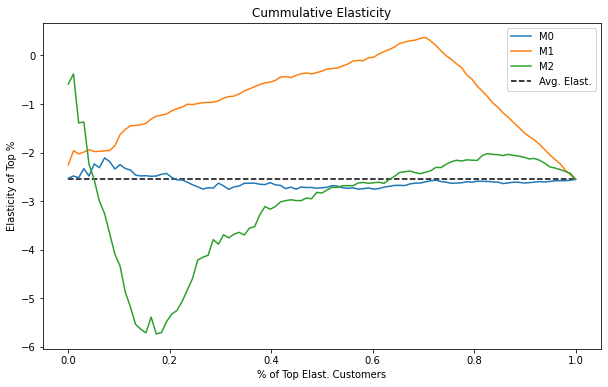

In [11]:
plt.figure(figsize=(10,6))
for m in range(3):
    cumm_elast = top_n_elast_curve(prices_rnd_pred, f"m{m}_pred", "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumm_elast)))
    plt.plot(x/x.max(), cumm_elast, label=f"M{m}")

plt.hlines(elast(prices_rnd, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.title("Cummulative Elasticity")
plt.legend();

Consider now the elasticity model M1. It starts of with a elasticity close to the average but it soon diverges up. This means that it's ordering puts units with higher elasticity in front of those units with lowe elasticity. By the time it reaches 40% of the samples, the elasticity is only about -0.5. This means that this model can indeed order elasticity. If we increase prices on days like those like top 40%, we shold expect sales to decrease only 0.5 units for each BRL increase. This is a much lower sensitivity than the average -2.5. However, this is not a perfect model in its ordering. We can see that the top 20% have an elasticity that is higer than that of the top 40%, meaning this region of the model does not satisfy \\(F(k) > F(k+n)\\).

Finaly, consider our predictive model. Its starts above the average elasticity, but then it goes down and it climbs back up to be pretty close to the averae elasticity. All this wiggling is some indication that it is not doing a very good job in ordering units by how elastic they are.

The cummulative elasticity plot already gives us some nice intuition about which model is better. However, its main purpuse is to aid decision making. With it, we can statements like "If I treat x% of my units, the effectivness of the treatment will be y". In our example, "If I increase prices on 40% of the units, the elasticity would be only -1.0". For model selection, we can use something that is vizually more appealing: the Qini curve.

To get the Qini, we only need one small ajustment. The idea it to multiply the elasticity by the propostion of samples that have that elasticity. 

$$
(F(k)(k/N), F(2k)(2k/N), F(3k)(3k/N),..., F(N))
$$



In [12]:
def cummulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

This produces the following curves for our models. In the Qini, a theoretical random model goes from 0 to the average elasticity. Indeed, if we look at our random model (M0), it folows closely the theoretical random line. On the Qini curve, the biger the Area Under the Curve, the better the model at ordering the elasticity. So, consider again our elasticity model M1 and the predictive model M2. It is pretty clear that the elasticity model has a much bigger area under the curve than the predictive model. For this reason, it's offten easier to know which model is better by looking at the Qini curve.

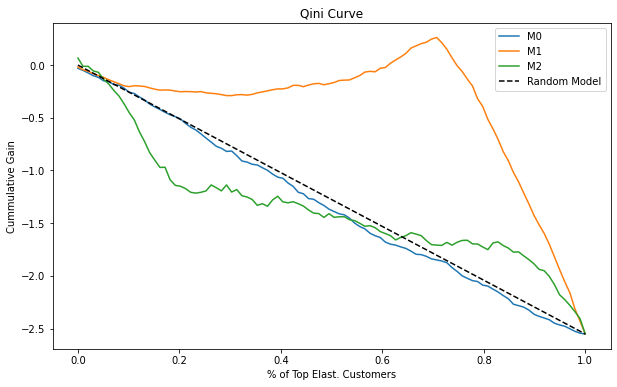

In [13]:
plt.figure(figsize=(10,6))

for m in range(3):
    cumm_gain = cummulative_gain(prices_rnd_pred, f"m{m}_pred", "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumm_gain)))
    plt.plot(x/x.max(), cumm_gain, label=f"M{m}")
    
plt.plot([0, 1], [0, elast(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Gain")
plt.title("Qini Curve")
plt.legend();

One downside of evaluation like the ones above is that they all deppend on having random data. That is because we need to trust our elasticity estimation, which is very complicated thing to do in the absense of random data. For all intend and purposes, I would only recomend those evaluations if you have some random data. However, this is not always possible. When it is not, there is still a way out, but I would still aproach it very critically. 

## Non Random Data

Cummulative elasticity and the Qini curves need to estimate the average elasticity of a sample in order to work properly. Remember that the average elasticity is the end point of the curves we've seen above. Is the average elasticity is off, the whole thing blows up. To give an example, let's say that, on our icecream example, because we used to rise prices during the weekends, it looked like the higher the price, the higher the sales ammount (wihch is obvious nonsense). When we plot such a Qini curve, it would look like the average price elasticity is positive and we would look for models that can segment the sample in a way to make it even more positive. Of course, this doesn't make any sence, since economic theory tells us that sales should go down as we increase price.

To correct that, we need to somehow debias our data. To show you how to do that, consider that we don't have access to the random data anymore. Now, we have to split our non random data into a training and a validation set.

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

Next, we have to make it so that the evaluation or test set is not biased.

## Debiasing the Test

If we show the correlation on the test set, we can see that price is positively correlated with sales, meaning that sales should go up as we increase prices. This is obviously nonsense

In [15]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,-0.011791,0.004071,0.009437,0.376438
weekday,-0.011791,1.000000,0.012182,0.001593,0.006172
cost,0.004071,0.012182,1.000000,0.397086,-0.006410
price,0.009437,0.001593,0.397086,1.000000,0.082373
sales,0.376438,0.006172,-0.006410,0.082373,1.000000


If we plot our data, we can see why this is happening. Weekends (Saturday and Sunday) have higer price but also higher sales. We can see that this is the case because the weekend cloud of points seems to be to the right upper part of the plot. This idicates the same sort of bias we where talking about earlier.

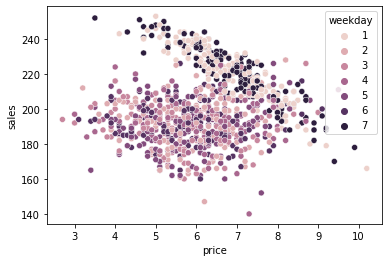

In [16]:
np.random.seed(123)
sns.scatterplot(data=test.sample(1000), x="price", y="sales", hue="weekday");

To debias this dataset we will need to models. The first model, let's call it \\(M_t(X)\\), predicts the treatment (price, in our case) using the confounder. Here, we will use a regression model for \\(M_t(X)\\).

In [17]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test)})

Once we have this model, we will construct the residuals

$$
\hat{t}_i = t_i - M_t(X_i)
$$

You can think of this residual as a version of the treatment that is unbiased or, better yet, that is inpossible to predict from the confounders \\(X\\). Since the confounders where already used to predict \\(t\\), the residual is by definition, unpredictable with \\(X\\). Another way of saying this is that the biase have been explained away by the model \\(M_t(X_i)\\), prudicing \\(\hat{t}_i\\) wich is as good as randomm

Of course this only works if we have in \\(X\\) all the confounders that causes both \\(T\\) and \\(Y\\). Just for the sake of ilustration, here is what happens to the data when we debiased \\(t\\). 

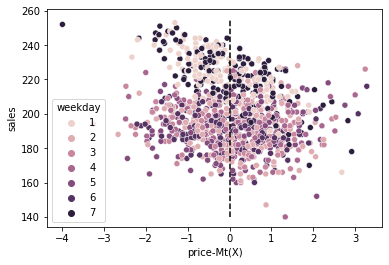

In [18]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales", hue="weekday")
plt.vlines(0, debiased_test["sales"].min(), debiased_test["sales"].max(), linestyles='--', color="black");

We can see that the weekends are no longer to the upper right corned. They got pushed to the center. As we can see, price (the treatment) doesn't differentiate in any sistematic way according to the weekday.

This alone is suficient to debias the dataset. But we can still do one other thing to make the debiased sample better. Namely, we can also contruct residuals for the outcome.


$$
\hat{y}_i = y_i - M_y(X_i)
$$

This doesn't make the set less biased, but it makes it easier to estimate the elasticity. Once again, you can think about \\(\hat{y}_i\\) as a version of \\(y_i\\) that is unpredictable from \\(X\\) or that had all its variances due to \\(X\\) explained away. If that is the case, the only thing left to explain \\(\hat{y}_i\\) is something we didn't used to construct it (not included in \\(X\\)), wich is only the treatment. 


In [19]:
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test),
                               "sales-My(X)":test["sales"] - m_y.predict(test)})

Once we do such transformation, not only does weekday can't predict price, but now it can't also predict the residual of sales \\(\hat{y}\\). The only think left to predict this residual is the treatment. Also, notice something interesting. In the plot above, it was hard to know the direction of the price elasticity. It looked like as prices go up, sales go down, but there whas such a large variance in sales that it was hard to say that for sure. Now, when we plot the two residuals, it becomes much clear that sales indeed causes prices to go down.

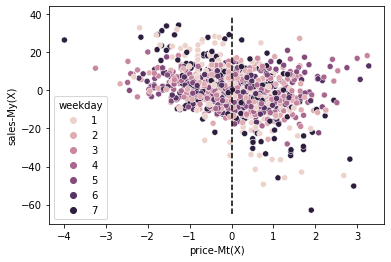

In [20]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales-My(X)", hue="weekday")
plt.vlines(0, debiased_test["sales-My(X)"].min(), debiased_test["sales-My(X)"].max(), linestyles='--', color="black");

To summarize, by predicting the treatment, we've constructed \\(\hat{t}\\) which works as an unbiased version of the treatment; by predicting the outcome, we've contructed \\(\hat{y}\\) wich is a version of the outcome that is only explained by the treatment

Now that we have a version of the test wich is debiased, we can proceede like we did before with our elasticity model. First, we fit it on the training set.

In [21]:
m3 = smf.ols(f"sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

Then, we make elasticity predictions on the debiased test set.

In [22]:
debiased_test_pred = debiased_test.assign(**{
    "m3_pred": predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,price-Mt(X),sales-My(X),m3_pred
5770,28.9,6,1.0,6.9,210,0.866784,9.472567,-1.793514
9436,25.7,7,0.5,6.7,235,0.229630,10.497228,-13.191531
4098,22.6,3,0.5,5.6,171,0.154908,-18.420336,1.289809
7922,20.7,6,1.0,6.8,187,0.779103,1.319554,1.114852
1548,29.4,3,1.0,6.7,214,0.735878,12.684552,-1.805416


Now, when it comes to ploting the cummulative elasticity, we still order the dataset by the predictive elasticity, but now we use the debiased versions of the treatment and outcome to get the elasticity. This is equivalent to estimating \\(\beta_1\\) in the folowing regression model

$$
\hat{y}_i = \beta_0 + \beta_1 \hat{t}_i + e_i
$$

where the residuals have been made like we've described before.

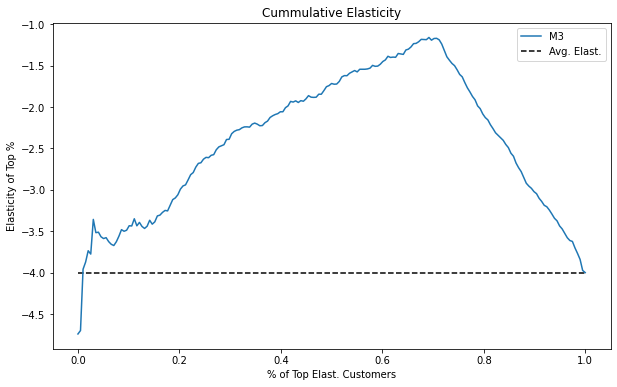

In [23]:
plt.figure(figsize=(10,6))

cumm_elast = top_n_elast_curve(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_elast)))
plt.plot(x/x.max(), cumm_elast, label=f"M3")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.title("Cummulative Elasticity")
plt.legend();

We can do the same thing for the Qini curve, of course.

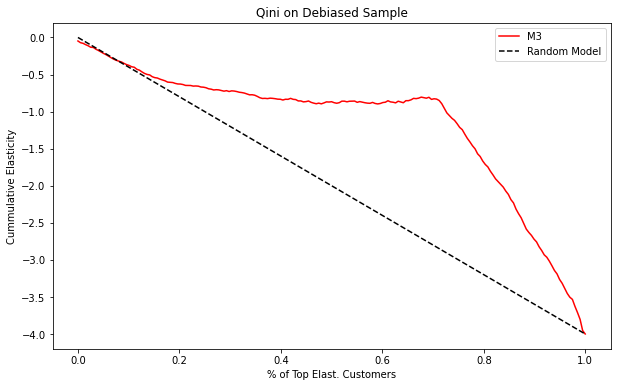

In [24]:
plt.figure(figsize=(10,6))

cumm_gain = cummulative_gain(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M3", color="red")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Elasticity")
plt.title("Qini on Debiased Sample")
plt.legend();

And just to give you a sense of how inportant it is to debiase the set when computing the Qini curve, here is what it looks like if isetad use the biased sample. Notice that the price elasticity goes up, which is complete nonsense. As a result, a model that is good looks terrible.

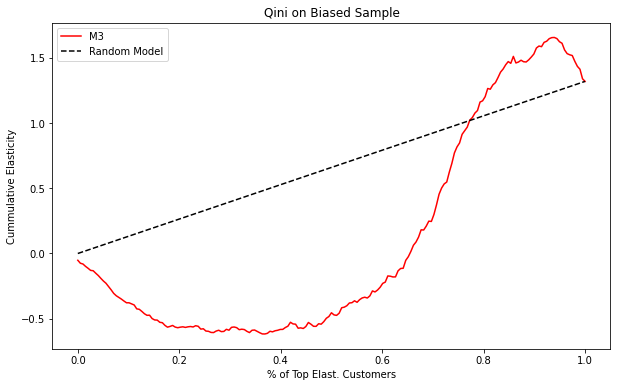

In [25]:
plt.figure(figsize=(10,6))

cumm_gain = cummulative_gain(debiased_test_pred, "m3_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, label=f"M3", color="red")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.title("Qini on Biased Sample")
plt.ylabel("Cummulative Elasticity")
plt.legend();

## Considering the Variance

Before we close, I just wanted to tuch on a brief topic wihch is variance. As well educated as we are in statistics, it feels wrong to not place a confidence interval around our Qini curve. Happly for us, since the Cummulative Elasticity curve is just the agregation of the coeficients of lots of linear regressions, we can place confidence interval around those estimates fairly easely. 

To achive such a thing, we will first create a function that returns the CI for use. I'm using the formula for the simple linear regression here

$$
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$$

but feel free to extract the CI however you want.

In [26]:
def elast_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = elast(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

Now, we only need a minor modification on our `top_n_elast_curve` function. Instead of outputing the elasticity, we will now output the confidence interval for the elasticity.

In [27]:
def top_n_elast_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    return np.array([elast_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

And finally, here is the cummulative elasticity curve with the 95% CI.

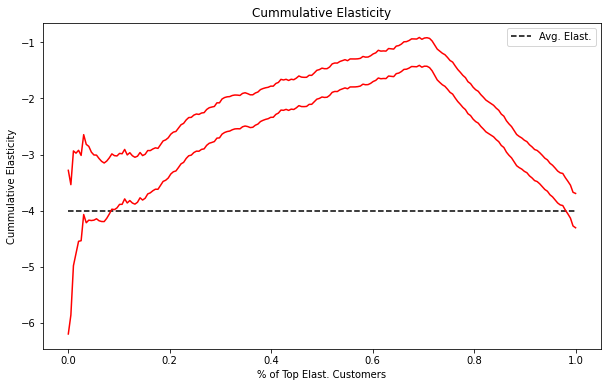

In [28]:
plt.figure(figsize=(10,6))

cumm_gain = top_n_elast_curve_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="red")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cummulative Elasticity")
plt.title("Cummulative Elasticity")
plt.legend();

## Key Ideas